In [1]:
import numpy as np
import joblib
import pandas as pd
import torch
from torch import nn,optim
from tqdm import tqdm 
from torch.utils.data import TensorDataset,DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
with open("X_train.joblib", mode="rb") as f:
    X_train = joblib.load(f)

X_train = torch.tensor(X_train).to(device)

with open("y_train.joblib", mode="rb") as f:
    y_train = joblib.load(f)

y_train = torch.tensor(y_train,dtype=torch.long).to(device)


with open("X_valid.joblib", mode="rb") as f:
    X_valid = joblib.load(f)

X_valid = torch.tensor(X_valid).to(device)

with open("y_valid.joblib", mode="rb") as f:
    y_valid = joblib.load(f)

y_valid = torch.tensor(y_valid,dtype=torch.long).to(device)

In [23]:
ds = TensorDataset(X_train,y_train)
loss_func = nn.CrossEntropyLoss()

model = nn.Sequential(
    nn.Linear(X_train.size()[1], 100),
    nn.PReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 25),
    nn.PReLU(),
    nn.BatchNorm1d(25),
    nn.Linear(25, 4)
)
model.to(device)

Sequential(
  (0): Linear(in_features=300, out_features=100, bias=True)
  (1): PReLU(num_parameters=1)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=100, out_features=25, bias=True)
  (4): PReLU(num_parameters=1)
  (5): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=25, out_features=4, bias=True)
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


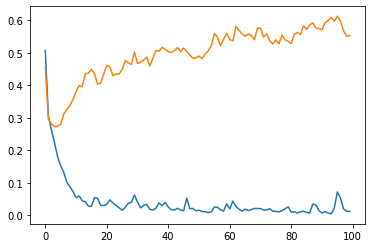

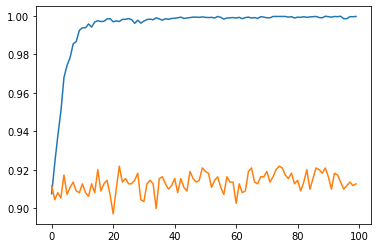

In [24]:
for batchsize in [64]:
    optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0)
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
    data_loader = torch.utils.data.DataLoader(ds,batch_size=batchsize, shuffle=True)
    
    for epoch in tqdm(range(100)):
        train_loss_accum = 0.0
        valid_loss_accum = 0.0
        
        for xx,yy in data_loader:
            optimizer.zero_grad()
            y_pred = model(xx)
            out = loss_func(y_pred,yy)
            out.backward()
            optimizer.step()
            train_loss_accum += out.item()
            valid_loss_accum += loss_func(model(X_valid),y_valid).item()
        #joblib.dump(model.state_dict(), f'state_dict_{epoch}.joblib')

        train_loss.append(train_loss_accum/len(data_loader))
        valid_loss.append(valid_loss_accum/len(data_loader))

        y_pred_train = torch.max(model(X_train),1)[1]
        y_pred_valid = torch.max(model(X_valid),1)[1]
        train_acc.append((y_pred_train == y_train).sum().item() / len(y_train))
        valid_acc.append((y_pred_valid == y_valid).sum().item() / len(y_valid))
    plt.plot(range(100),train_loss)
    plt.plot(range(100),valid_loss)
    plt.show()
    plt.plot(range(100),train_acc)
    plt.plot(range(100),valid_acc)
    plt.show()